# ⚛️ LiH — Noiseless VQE Ground-State Simulation (UCCSD)

This notebook computes the **ground state energy of lithium hydride (LiH)**  
using a **noiseless Variational Quantum Eigensolver (VQE)** with your
production VQE package:

```python
from vqe.core import run_vqe
```

---

## Simulation setup

- Molecule: **LiH**
- Basis: **STO-3G**
- Electrons: **4** (Li: 3, H: 1)
- Ansatz: **UCCSD** (singles + doubles)
- Optimizer: **Adam**
- Device: **default.qubit** (statevector, noiseless)

## Outputs

- Convergence of VQE energy vs iteration  
- Final ground-state energy  
- Ground-state decomposition into significant basis states  
- Bar plot of amplitudes  

This notebook is a **pure client** of the VQE package — no manual QNodes,
devices, or custom optimisers.

In [5]:
import os
import sys

import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem

# Allow the notebook to import the local package when run from source
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.core import run_vqe
from vqe_qpe_common.molecules import get_molecule_config
from vqe_qpe_common.plotting import IMG_DIR
from vqe_qpe_common.molecule_viz import plot_molecule

# 🧬 Part 1 — LiH Molecular Information

We query the **shared molecule registry** for LiH, then reconstruct:

- the molecular Hamiltonian  
- the Hartree–Fock reference state  

This section is informational only — the *actual* VQE run is handled by
`run_vqe` below.

In [6]:
mol = get_molecule_config("LiH")
print("Loaded LiH configuration from registry:")
print(mol)

symbols = mol["symbols"]
coordinates = mol["coordinates"]
basis = mol["basis"]
charge = mol["charge"]

# Li (3 e⁻) + H (1 e⁻) = 4 electrons
electrons = 4

ham, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=charge,
    basis=basis,
)

hf = qchem.hf_state(electrons, qubits)

print(f"\nLiH → {qubits} qubits")
print("HF state =", "|" + "".join(str(int(b)) for b in hf) + "⟩")

Loaded LiH configuration from registry:
{'symbols': ['Li', 'H'], 'coordinates': array([[0. , 0. , 0. ],
       [0. , 0. , 1.6]]), 'charge': 0, 'basis': 'STO-3G'}

LiH → 12 qubits
HF state = |111100000000⟩


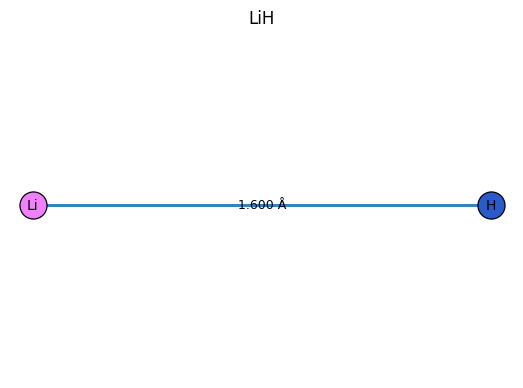

In [7]:
plot_molecule(
    symbols,
    coordinates,
    title="LiH",
    bonds=[(0, 1)],
    angles=[],
    show_bond_lengths=True,
    show_atom_indices=False,
)
plt.show()

# 🚀 Part 2 — Run Noiseless VQE (Package API)

We now call:

```python
run_vqe(
    molecule="LiH",
    ansatz_name="UCCSD",
    optimizer_name="Adam",
    ...
)
```

All of the following is handled internally:

- Hamiltonian construction  
- UCCSD ansatz building  
- Device selection (`default.qubit`)  
- Optimisation loop  
- Caching of results to disk  
- Final state reconstruction  

The returned dictionary includes:

- `"energy"`: final ground-state estimate  
- `"energies"`: convergence trajectory  
- `"num_qubits"`: number of qubits  
- `"final_state_real"`, `"final_state_imag"`: components of the final statevector  

In [8]:
result = run_vqe(
    molecule="LiH",
    ansatz_name="UCCSD",
    optimizer_name="Adam",
    n_steps=30,
    stepsize=0.2,
    noisy=False,
    plot=False,
    seed=0,
    force=False,
)

energies = result["energies"]
final_energy = result["energy"]
num_qubits = result["num_qubits"]

print(f"\n✅ VQE run complete.")
print(f"Final ground-state energy: {final_energy:.8f} Ha")
print(f"Number of iterations (including initial point): {len(energies)}")

KeyboardInterrupt: 

# 📉 Part 3 — Convergence Plot

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(energies, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("LiH VQE Convergence (Noiseless, UCCSD + Adam)")
plt.grid(True, alpha=0.4)
plt.tight_layout()

fname_conv = os.path.join(IMG_DIR, "LiH_Noiseless_UCCSD_Convergence.png")
plt.savefig(fname_conv, dpi=300)
plt.show()

print(f"📁 Saved convergence plot to: {fname_conv}")

# 🔍 Part 4 — Ground-State Reconstruction

We reconstruct the final statevector:

$$
|\psi\rangle = \sum_i c_i |i\rangle
$$

from the stored real and imaginary components and print only those basis
states with:

$$
|c_i| > 10^{-2}.
$$

In [ ]:
psi_r = np.array(result["final_state_real"], dtype=float)
psi_i = np.array(result["final_state_imag"], dtype=float)
psi = psi_r + 1j * psi_i

threshold = 1e-2
indices = np.where(np.abs(psi) > threshold)[0]

ket_terms = []
for idx in indices:
    amp = psi[idx]
    bitstr = f"|{idx:0{num_qubits}b}⟩"

    if abs(amp.imag) < 1e-6:
        amp_str = f"{amp.real:.4f}"
    else:
        amp_str = f"({amp.real:.4f}+{amp.imag:.4f}j)"

    ket_terms.append(f"{amp_str}{bitstr}")

print("\nSignificant components of |ψ⟩ (|c_i| > 1e-2):")
print(" |ψ⟩ ≈ " + " + ".join(ket_terms))

# 📊 Part 5 — Amplitude Bar Plot

Finally, we visualise the magnitude of the significant amplitudes as a
simple bar plot.

In [ ]:
labels = [f"|{idx:0{num_qubits}b}⟩" for idx in indices]
magnitudes = np.abs(psi[indices])

plt.figure(figsize=(10, 5))
plt.bar(labels, magnitudes)
plt.xlabel("Computational basis state")
plt.ylabel("Amplitude |cᵢ|")
plt.title("LiH VQE Ground-State Amplitudes (Noiseless, UCCSD)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

fname_amps = os.path.join(IMG_DIR, "LiH_Noiseless_UCCSD_Ground_State.png")
plt.savefig(fname_amps, dpi=300)
plt.show()

print(f"📁 Saved amplitude plot to: {fname_amps}")